# Feature Selection: remove redundant features

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

sys.path.insert(0,'../src/training/')
from utils import (
    RANDOM_STATE,
    INFREQUENT_STOPPAGE_EVENTS,
    TRAIN_COLS_PART_4,
    LABEL_COL,
    clf_performance_metrics,
    log_experiment,
    register_model,
)
from visuals import generate_shot_classifier_charts

In [2]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    X_train, Y_train =  train[TRAIN_COLS_PART_4], train[LABEL_COL].astype(int)
    X_val, Y_val = val[TRAIN_COLS_PART_4], val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val


def preprocess(X_train, X_val):
    X_train['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_train['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_val['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_val['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_train = pd.get_dummies(X_train, ['shot', 'prev_event'])
    X_val = pd.get_dummies(X_val, ['shot', 'prev_event'])

    return X_train, X_val

In [3]:
# Training and validation data with all the features from Q4
X_train, Y_train, X_val, Y_val = load_train_and_validation()
X_train, X_val = preprocess(X_train, X_val)

In [4]:
X_train.columns

Index(['game_sec', 'period', 'coordinate_x', 'coordinate_y',
       'distance_from_net', 'angle', 'angle_between_prev_event',
       'distance_from_prev_event', 'prev_event_time_diff', 'speed',
       'is_rebound', 'rebound_angle', 'is_empty_net', 'shot_Backhand',
       'shot_Deflected', 'shot_Slap Shot', 'shot_Snap Shot', 'shot_Tip-In',
       'shot_Wrap-around', 'shot_Wrist Shot', 'prev_event_BLOCKED_SHOT',
       'prev_event_FACEOFF', 'prev_event_GIVEAWAY', 'prev_event_HIT',
       'prev_event_MISSED_SHOT', 'prev_event_SHOT', 'prev_event_STOP',
       'prev_event_TAKEAWAY'],
      dtype='object')

In [5]:
data = X_train.copy()
data['outcome'] = Y_train.copy()
data.corr()['outcome'].sort_values(ascending=False)

outcome                     1.000000
is_empty_net                0.209351
coordinate_x                0.117013
shot_Tip-In                 0.063804
game_sec                    0.055294
period                      0.052393
prev_event_SHOT             0.052195
speed                       0.043235
shot_Deflected              0.037056
prev_event_GIVEAWAY         0.024836
shot_Backhand               0.020695
prev_event_TAKEAWAY         0.012792
prev_event_MISSED_SHOT      0.007763
prev_event_STOP             0.004620
shot_Snap Shot              0.003185
prev_event_BLOCKED_SHOT     0.001508
coordinate_y               -0.001047
angle                      -0.001521
shot_Wrap-around           -0.007115
shot_Wrist Shot            -0.014695
distance_from_prev_event   -0.015766
angle_between_prev_event   -0.032148
prev_event_HIT             -0.040855
prev_event_FACEOFF         -0.044320
shot_Slap Shot             -0.048743
prev_event_time_diff       -0.054921
rebound_angle              -0.092694
i

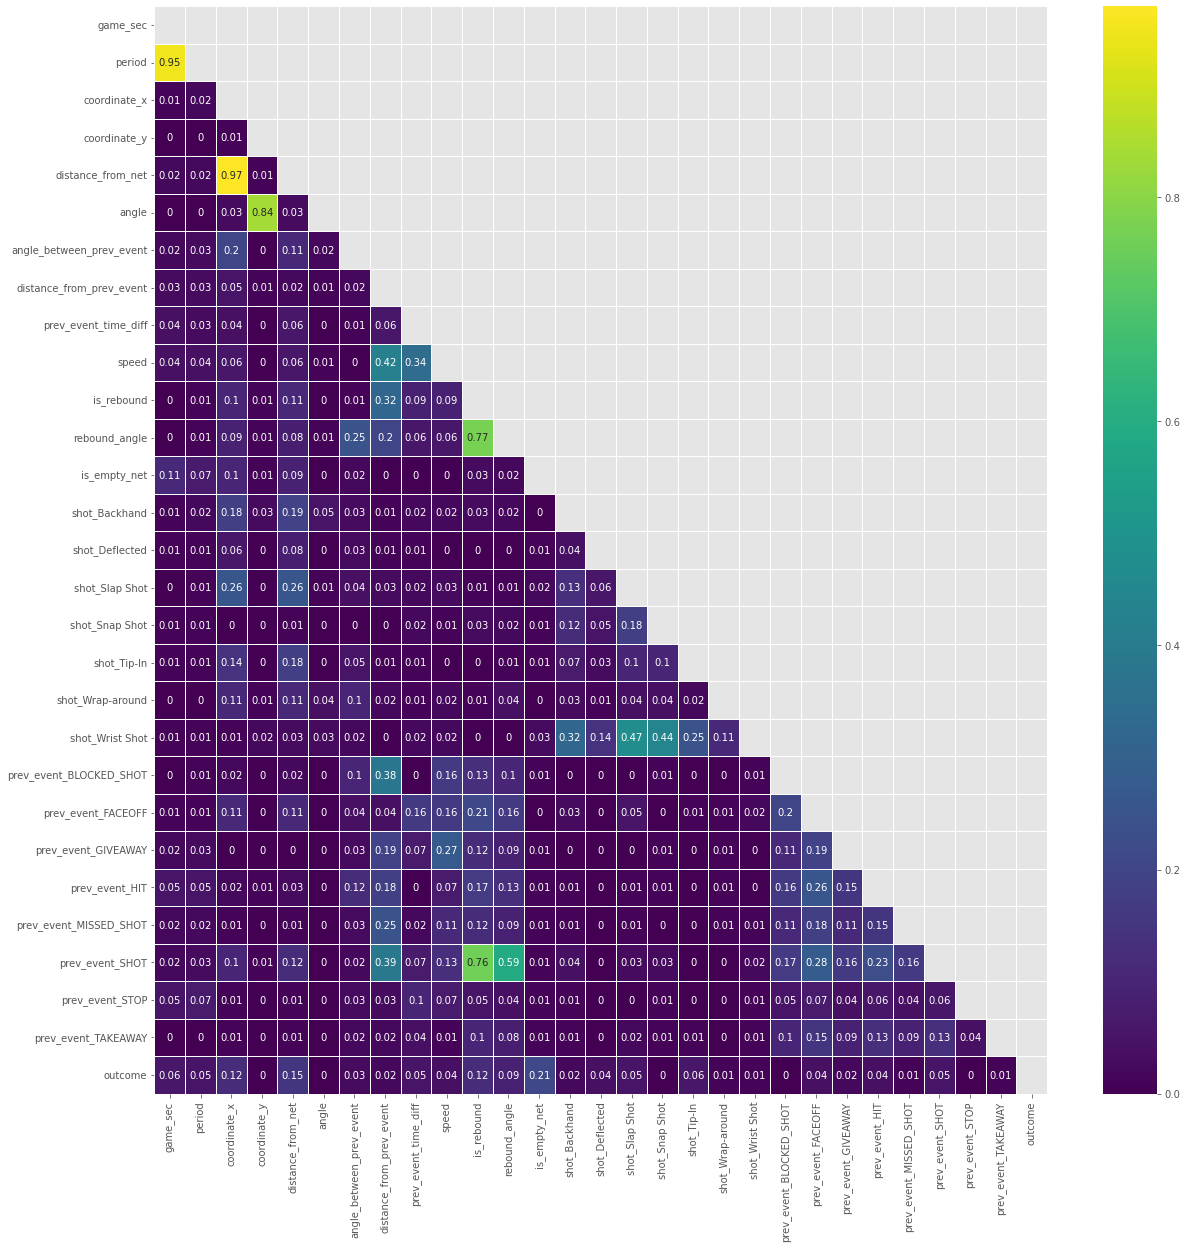

In [6]:
plt.figure(figsize=(20, 20))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs().round(2), mask=mask, annot=True, linewidths=.5, cmap='viridis');
plt.savefig("../figures/features_correlation.png", bbox_inches='tight', dpi = 300)

In [7]:
# redundant features 
redundant_feats = ['is_rebound', 'coordinate_y', 'coordinate_x', 'period']

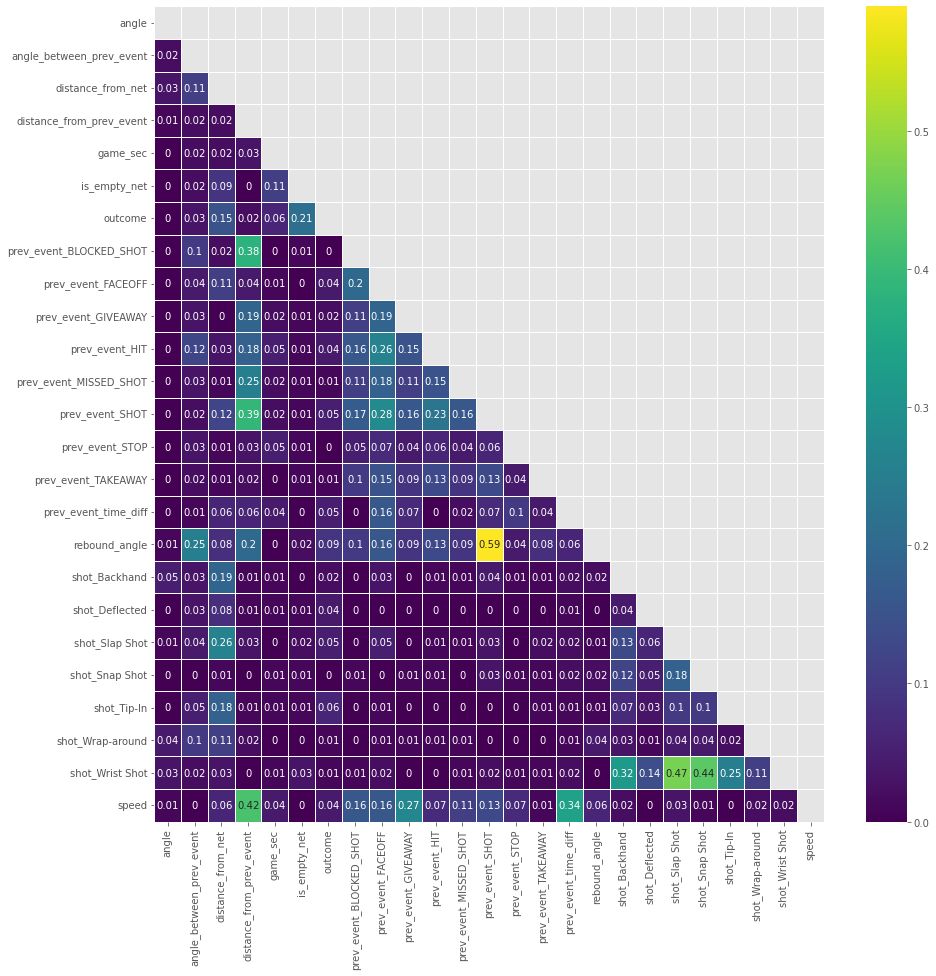

In [8]:
# correlation between current features
plt.figure(figsize=(15, 15))
new_corr = data[data.columns.difference(redundant_feats)].corr() 
mask = np.tri(*new_corr.shape).T 
sns.heatmap(new_corr.abs().round(2), mask=mask, annot=True, linewidths=.5, cmap='viridis');
plt.savefig("../figures/features_non_correlated.png", bbox_inches='tight', dpi = 300)

In [8]:
# Training and validation data of the selected features
selected_feats = X_train.columns.difference(redundant_feats)
X_train, X_val = X_train[selected_feats], X_val[selected_feats]

### Tuning XGBoost model with the selected features

In [9]:
# hyperparams search
def get_xgboost_hparams_tuning(X, y, feat_select_method_name,
                               save_result_path="../models/hparams_results/"):

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss', use_label_encoder=False
    )

    hparam_search_ranges = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 6),
        "colsample_bytree": uniform(.33, 1-.33),
        "subsample": uniform(0.5, 1-.5),
        "learning_rate": uniform(0.03, .67-.03),
        "gamma": uniform(0, 0.5)
    }

    search = RandomizedSearchCV(
        xgb_model, param_distributions=hparam_search_ranges,
        random_state=1729, n_iter=50, cv=5, verbose=2, n_jobs=1, return_train_score=True, refit=True
    )

    search.fit(X.values, y.values)

    search_results_summary = pd.DataFrame(search.cv_results_)
    
    if not os.path.exists(save_result_path):
        os.makedirs(save_result_path)
        
    search_results_summary.to_csv(os.path.join(save_result_path, feat_select_method_name + ".csv"))

    clf_optimal = search.best_estimator_
    opt_params={key:getattr(clf_optimal,key) for key in hparam_search_ranges}
    
    return clf_optimal, opt_params


In [4]:
# # hparams tuning with selected lasso features
# clf_optimal, opt_params = get_xgboost_hparams_tuning(X_train, Y_train,
#                                  feat_select_method_name = "hparams_feat_corr",
#                                  save_result_path="../models/hparams_results/")

In [11]:
opt_params

{'n_estimators': 495,
 'max_depth': 5,
 'colsample_bytree': 0.5395748217887331,
 'subsample': 0.9262101866374273,
 'learning_rate': 0.06161853852618868,
 'gamma': 0.18476657843168925}

### Training the tuned XGBoost model

In [15]:
# chosen via results of hparam optimization search
params = {
    'max_depth':5, 'n_estimators': 495, 'learning_rate': 0.062, 'gamma': 0.184,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

# params = opt_params

clf_feat_corr = xgb.XGBClassifier(**params)
clf_feat_corr.fit(X_train, Y_train)

y_pred = clf_feat_corr.predict(X_val)
y_proba = clf_feat_corr.predict_proba(X_val)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_feats_corr"
res.to_csv(f"../models/predictions/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)
perf_metrics

INFO:root:Accuracy is  0.922
INFO:root:Confusion Matrix:
 [[46055    77]
 [ 3913   916]]
INFO:root:F1 score is  0.315
INFO:root:Precision score is  0.922
INFO:root:Recall score is  0.190


{'accuracy': 0.9217048331076706,
 'f1_score': 0.31466849879766406,
 'precision': 0.9224572004028198,
 'recall': 0.1896873058604266}

# Visualizing best performer models

In [16]:
def generate_adv_model_figures():
    experiment_prediction_filenames = {
        "xgboost_lasso": "/home/sara/Downloads/hockey/models/predictions/xgboost_lasso.csv",
        "NN_adv": "/home/sara/Downloads/hockey/models/predictions/NN_adv.csv",
        "xgboost_feats_corr": "/home/sara/Downloads/DS_xgboost/xgboost_feats_corr.csv",
    }

    exp_preds = {exp: pd.read_csv(fname) for exp, fname in experiment_prediction_filenames.items()}

    exp_names, y_trues, y_preds, y_probas = [], [], [], []
    for exp, preds in exp_preds.items():
        exp_names.append(exp)
        y_trues.append(preds['y_true'].values)
        y_preds.append(preds['y_preds'].values)
        y_probas.append(preds['y_proba'].values)

    title = "Visual Summary - XGBoost Models"
    image_dir = "/home/sara/Downloads/DS_figures/"

    generate_shot_classifier_charts(
        y_trues, y_preds, y_probas, exp_names,
        title=title, image_dir=image_dir
    )

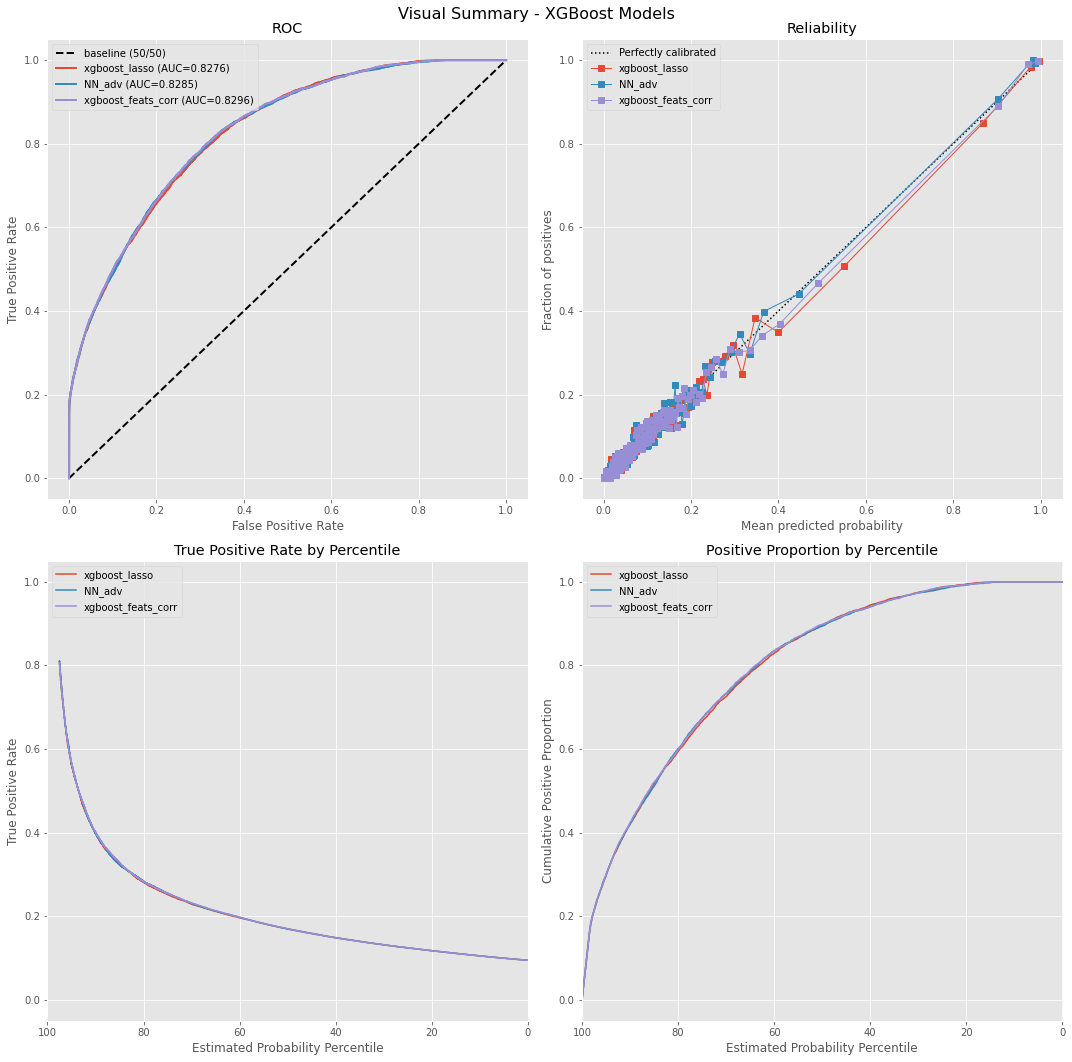

In [19]:
generate_adv_model_figures()